# Exploring the Spaceship titanic dataset

# Imports

#### Standard library imports

In [1]:
import sys
sys.path.append("../")
import os

#### Third party imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Local application imports

In [3]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# Loading data
- Training dataset

In [4]:
dftr = pd.read_csv(data_training)

# Processing data based on the data schema

In [5]:
dftr = data_wrangling_schema_functions(dftr, titanicsp_data_schema)

In [18]:
dftr

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,AllExpenses
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,187.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3668.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,1847.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,526.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,6893.0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,0.0
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1872.0
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,4284.0


# Individual features exploration

## PassengerId
A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

### Groups of traveling passengers

In [ ]:
dfx = dftr['PassengerId'].str.split(pat='_', expand=True)

In [ ]:
dfx[0].value_counts()

This shows that the group information is quite scattered in many small groups (there are only 1,412 groups that have more than one person; 3,888 entries belong to these groups). Therefore, it might not be a good idea to use it as an additional feature.

### Relation between the group and the missing people
- Do people tend to disappear in groups? 

In [ ]:
dfx = pd.concat(
    [
        dftr['PassengerId'].str.split(pat='_', expand=True),
        dftr['Transported']
    ],
    axis=1,
)

In [ ]:
dfx2 = dfx[0].value_counts().to_frame()
lx = dfx2[dfx2[0] > 1].index

In [ ]:
dfx = dfx[dfx[0].isin(lx)].groupby(
    [
        dfx[0],
        dfx['Transported']
    ]
).agg(
    count=(1, 'count'),
)

## HomePlanet
The planet the passenger departed from, typically their planet of permanent residence.

### Count per category

In [ ]:
dftr['HomePlanet'].value_counts(normalize=True)

In [ ]:
plt.hist(dftr['HomePlanet'])

plt.show()

### Missing values

*Note*

Maybe a good way to fill missing values is using the group information present in the id feature

## CryoSleep 
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.


### Value counts

In [ ]:
dftr['CryoSleep'].value_counts(normalize=True)

## Cabin
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.


### Separating column in components

In [ ]:
dfx = pd.concat(
    [
        dftr['Cabin'].str.split(pat='/', expand=True),
        dftr['Transported'],
    ],
    axis=1
)

### Deck

In [ ]:
dfx[0].value_counts(normalize=True)

### Number

In [ ]:
dfx[1].value_counts(normalize=True)

**Note**

This value is highly fragmented and might not be of relevance

### Side

In [ ]:
dfx[2].value_counts(normalize=True)

In [ ]:
dfx2 = dfx.groupby(
    [
        dfx[2],
        dfx['Transported'],
    ],
    as_index=False
).agg(
    count=(0, 'count')
)

dfx2['count_prop'] = dfx2['count'] / dfx2.groupby(2)['count'].transform('sum')

dfx2

**Note**

This simple grouping suggests that there is no clear difference between people in 'S' or 'P'

## Destination
The planet the passenger will be debarking to.

In [ ]:
dftr['Destination'].value_counts(normalize=True)

In [ ]:
plt.hist(
    x=dftr['Destination']
)

plt.show()

## Age
The age of the passenger.

### Assessing if the ages are only integers

In [ ]:
(dftr['Age'] - dftr['Age'].round(0)).unique()

### Analyzing the distribution of ages

In [ ]:
plt.hist(
    x=dftr['Age'],
)

plt.show()

## VIP
Whether the passenger has paid for special VIP service during the voyage.

In [ ]:
dftr['VIP'].value_counts(True)

In [ ]:
dfx2 = dftr.groupby(
    [
        dftr['VIP'],
        dftr['Transported'],
    ],
    as_index=False
).agg(
    count=('PassengerId', 'count'),
)

dfx2['count_perc'] = dfx2['count'] / dfx2.groupby('VIP')['count'].transform('sum')

In [ ]:
g = sns.catplot(
    data=dfx2,
    kind='bar',
    x='VIP',
    y='count_perc',
    hue='Transported',
)

g

**Note**

This results suggest that the category 'VIP' does have an influence on the Transportation

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

### Preparing data

In [8]:
dftr['AllExpenses'] = dftr['RoomService'] + dftr['FoodCourt'] + dftr['ShoppingMall'] + dftr['VRDeck']

In [10]:
dfx = pd.melt(
    dftr,
    id_vars=['PassengerId'],
    value_vars=['AllExpenses', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
)

In [11]:
dfx = pd.merge(
    left=dfx,
    right=dftr.loc[:, ['PassengerId', 'Transported']],
    how='left',
    left_on='PassengerId',
    right_on='PassengerId'
)

### Visualizing data

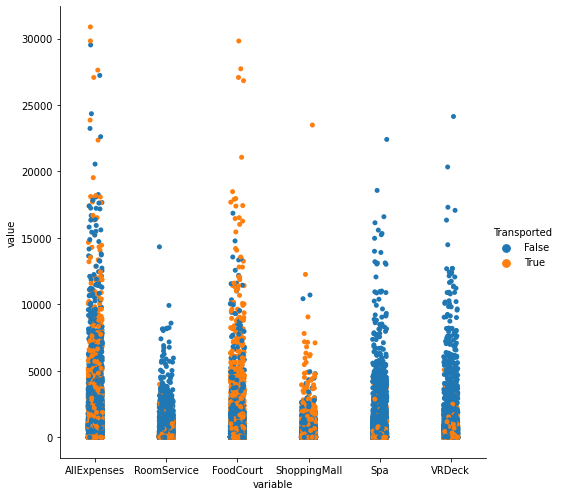

In [12]:
sns.catplot(
    data=dfx,
    x='variable',
    y='value',
    hue='Transported',
    height=7
)

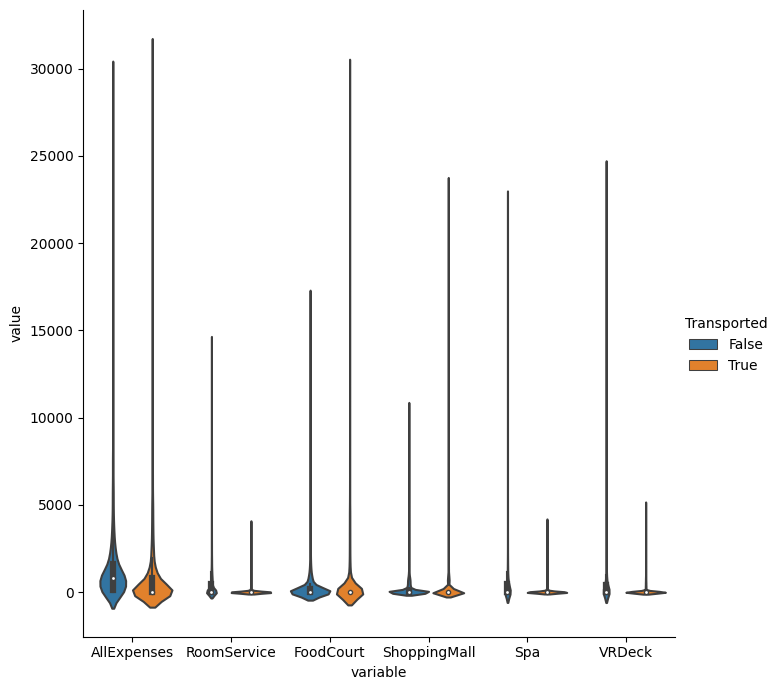

In [13]:
sns.catplot(
    data=dfx,
    x='variable',
    y='value',
    hue='Transported',
    kind='violin',
    height=7
)

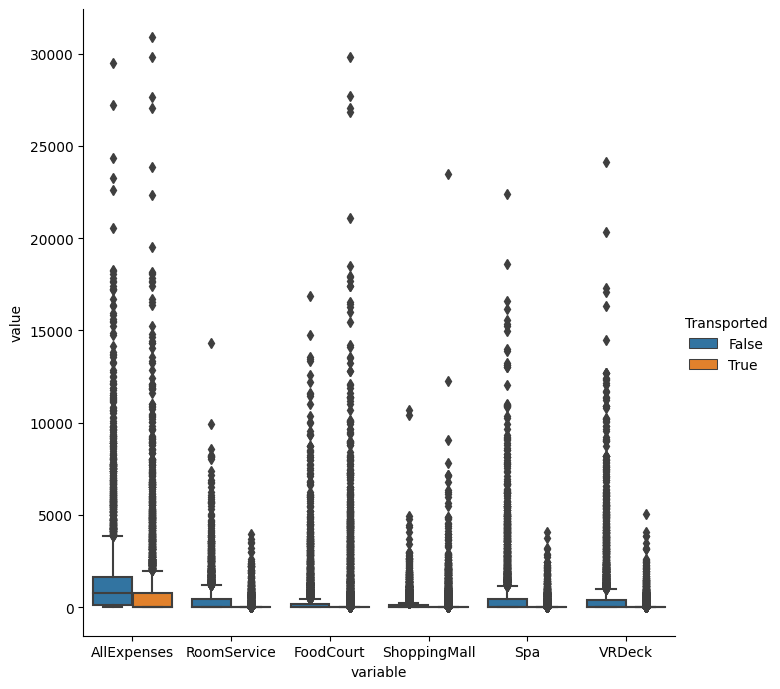

In [14]:
sns.catplot(
    data=dfx,
    x='variable',
    y='value',
    hue='Transported',
    kind='box',
    height=7
)

### Feature notes

**Note**

It is might be a good idea to reduce the expenses in a single category called "AllExpenses"

## Name
The first and last names of the passenger.

## Transported
Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


In [17]:
dftr['Transported'].value_counts(normalize=True)

True     0.503624
False    0.496376
Name: Transported, dtype: float64

# Header 1

## Header 1

# *Notes*

---

---